In [97]:
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax

import matplotlib.pyplot as plt
import scienceplots
from cmap import Colormap

In [98]:
cmap = Colormap("seaborn:mako").to_mpl()

In [129]:
N_COLLOCATION_POINTS = 500
N_DATA_POINTS = 20
N_MODELS_PER_DIM = 4

DATA_LOSS_WEIGHT = 10.0

LEARNING_RATE = 0.001
N_OPTIMIZATION_EPOCHS = 10000

XMIN = 0
XMAX = 2 * jnp.pi
YMIN = 0
YMAX = 2 * jnp.pi

In [133]:
model_centres = np.linspace(0, 1, N_MODELS_PER_DIM + 2)[1:-1]
print(model_centres)

[0.2 0.4 0.6 0.8]


In [123]:
def velocity_field(x, y):
    u = jnp.sin(x) * jnp.cos(y)
    v = -jnp.cos(x) * jnp.sin(y)
    return u, v

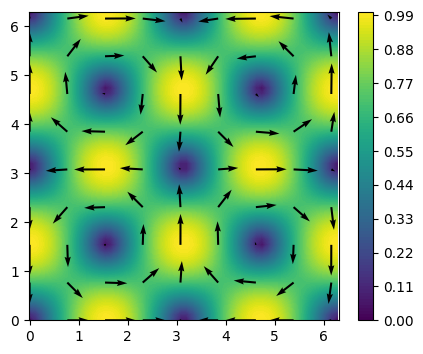

In [128]:
x_mesh = jnp.linspace(0, 2 * np.pi, 50)
y_mesh = jnp.linspace(0, 2 * np.pi, 50)

X, Y = jnp.meshgrid(x_mesh, y_mesh)

fig, ax = plt.subplots(figsize=(5, 4))

U, V = velocity_field(X, Y)
magnitude = jnp.sqrt(U**2 + V**2)
contour = ax.contourf(X, Y, magnitude, 100, cmap='viridis', vmax=1)
fig.colorbar(contour, ax=ax)
ax.axis('equal')
step = 6
ax.quiver(X[::step, ::step], Y[::step, ::step], U[::step, ::step], V[::step, ::step], color='k', scale=10)

In [102]:
def pressure_field(x, y):
    return 1 / 4 * (jnp.cos(2 * x) + jnp.sin(2 * y))

(0.0, 6.2831854820251465, 0.0, 6.2831854820251465)

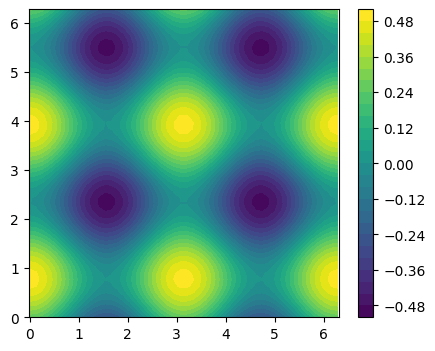

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

P = pressure_field(X, Y)
contour = ax.contourf(X, Y, P, 30, cmap='viridis', vmax=0.5)
fig.colorbar(contour, ax=ax)
ax.axis('equal')

In [104]:
key = jr.PRNGKey(42)

In [105]:
key, init_key = jr.split(key)
pinn = eqx.nn.MLP(
    in_size=2,
    out_size=2,
    width_size=10,
    depth=4,
    activation=jax.nn.sigmoid,
    key=key,
)

In [106]:
def pde_residuum(network, inputs):
    x = inputs[0]
    y = inputs[1]

    u_x = jax.grad(lambda x_: network(jnp.array([x_, y]))[0])(x)
    v_y = jax.grad(lambda y_: network(jnp.array([x, y_]))[1])(y)
    
    continuity_eqn = u_x + v_y

    return continuity_eqn

In [107]:
def data_residuum(network, inputs):
    x = inputs[0]
    y = inputs[1]
    
    u, v = velocity_field(x, y)
    
    return network(inputs) - jnp.stack([u, v], axis=-1)

In [119]:
key, coll_sampling_key = jr.split(key)
unscaled_coll_points = jax.random.uniform(coll_sampling_key, shape=(N_DATA_POINTS, 2), minval=0.0, maxval=1.0)
coll_points = unscaled_coll_points * jnp.array([XMAX, YMAX])

key, data_sampling_key = jr.split(key)
unscaled_data_points = jax.random.uniform(data_sampling_key, shape=(N_DATA_POINTS, 2), minval=0.0, maxval=1.0)
data_points = unscaled_data_points * jnp.array([XMAX, YMAX])

@eqx.filter_jit
def loss_fn(network):
    pde_res_coll = jax.vmap(pde_residuum, in_axes=(None, 0))(network, coll_points)
    pde_loss = jnp.mean(jnp.square(pde_res_coll))
    
    data_res = jax.vmap(data_residuum, in_axes=(None, 0))(network, data_points)
    data_loss = jnp.mean(jnp.square(data_res))
    
    total_loss = pde_loss + DATA_LOSS_WEIGHT * data_loss
    
    return total_loss

In [109]:
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(eqx.filter(pinn, eqx.is_array))
loss_history = []

In [120]:
@eqx.filter_jit
def make_step(network, state):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(network)
    updates, new_state = optimizer.update(grad, state, network)
    new_network = eqx.apply_updates(network, updates)
    return new_network, new_state, loss

for epoch in range(N_OPTIMIZATION_EPOCHS):
    pinn, opt_state, loss = make_step(pinn, opt_state)
    loss_history.append(loss)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, loss: {loss}")

Epoch: 0, loss: 0.4729383885860443
Epoch: 100, loss: 0.03276209905743599
Epoch: 200, loss: 0.01943049393594265
Epoch: 300, loss: 0.014021143317222595
Epoch: 400, loss: 0.010898230597376823
Epoch: 500, loss: 0.00891280360519886
Epoch: 600, loss: 0.0075489217415452
Epoch: 700, loss: 0.006529014091938734
Epoch: 800, loss: 0.005708812735974789
Epoch: 900, loss: 0.00502131599932909
Epoch: 1000, loss: 0.004437570460140705
Epoch: 1100, loss: 0.003941099159419537
Epoch: 1200, loss: 0.003517908975481987
Epoch: 1300, loss: 0.003155454294756055
Epoch: 1400, loss: 0.0028430453967303038
Epoch: 1500, loss: 0.002571907825767994
Epoch: 1600, loss: 0.0023349605035036802
Epoch: 1700, loss: 0.002126547507941723
Epoch: 1800, loss: 0.0019421059405431151
Epoch: 1900, loss: 0.001777920057065785
Epoch: 2000, loss: 0.001630952931009233
Epoch: 2100, loss: 0.0014987445902079344
Epoch: 2200, loss: 0.0013791820965707302
Epoch: 2300, loss: 0.0012706455308943987
Epoch: 2400, loss: 0.001171677839010954
Epoch: 2500, l

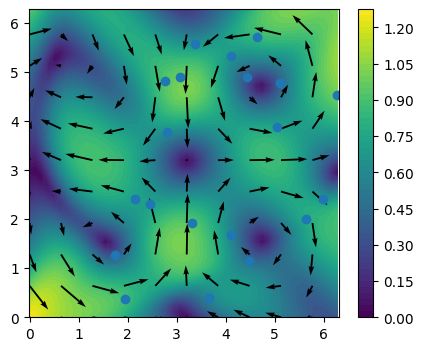

In [121]:
x_mesh = jnp.linspace(0, 2 * np.pi)
y_mesh = jnp.linspace(0, 2 * np.pi)
X, Y = jnp.meshgrid(x_mesh, y_mesh)

fig, ax = plt.subplots(figsize=(5, 4))

inputs = jnp.stack([X.flatten(), Y.flatten()], axis=-1)
output = jax.vmap(pinn)(inputs)
U, V = jnp.split(output, 2, axis=-1)
U = U.reshape(X.shape)
V = V.reshape(X.shape)

magnitude = jnp.sqrt(U**2 + V**2)

contour = ax.contourf(X, Y, magnitude, 60, cmap='viridis')
fig.colorbar(contour, ax=ax)
ax.axis('equal')
ax.quiver(X[::5, ::5], Y[::5, ::5], U[::5, ::5], V[::5, ::5], color='k', scale=10)
ax.scatter(data_points[:, 0], data_points[:, 1])

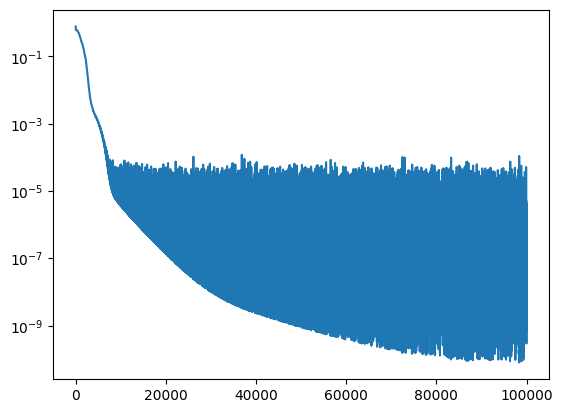

In [117]:
plt.plot(loss_history)
plt.yscale("log")